In [ ]:
# default_exp funcs.merfish_codenet

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_22/seed:3xnorm:nonexmodel_init:nullxmean_diff:True//train.yaml')

In [ ]:
cfg.genm.foci.n_foci_avg = 0
cfg.training.bs = 20
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = get_mop_codebook()

In [ ]:
# def target_from_matches(matches_df):
    
#     return np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)

# def verr_from_matches(matches_df):
    
#     gt_code = np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)
#     pred_int = matches_df[[f'int_pred_{i}' for i in range(16)]].values
    
#     corrs = [np.corrcoef(gt_code[i], pred_int[i])[0,1] for i in range(len(matches_df))]
    
#     return corrs
                    
# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str] + ['int'+df_str+f'_{i}' for i in range(16)] + ['int_sig'+df_str+f'_{i}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return df[input_keys].values

In [ ]:
# export

# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, codebook, targets, int_str=df_str)
#     matched_codes = codebook[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] + [f'int_{i}{df_str}' for i in range(16)] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return np.concatenate([df[input_keys].values, matched_codes], 1)

# def input_from_df(df, codebook, targets, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, codebook, targets, int_str=df_str)
#     matched_codes = codebook[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] #+ ['rec_rmses'] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     int_sum = df[[f'int_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
#     ints_sum = df[[f'int_sig_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
    
#     return np.concatenate([inp_arr, int_sum, ints_sum], 1)

def input_from_df(df):
                    
    input_keys = ['prob','x_sig','y_sig','z_sig'] + [f'int_sig_{i}' for i in range(4)]  + [f'int_{i}' for i in range(4)]
    inp_arr = df[input_keys].values
    
    return inp_arr
#     int_sum = df[[f'int_{i}' for i in range(16)]].values.sum(-1)[:,None]
#     ints_sum = df[[f'int_sig_{i}' for i in range(16)]].values.sum(-1)[:,None]
    
#     return np.concatenate([inp_arr, int_sum, ints_sum], 1)



# def target_from_matches(matches_df, codebook, targets):
    
#     matches_df = get_code_from_ints(matches_df, codebook, targets, int_str='_pred')
#     matched_codes = codebook[matches_df['code_inds'].values]
    
# #     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]]
# #     tar_code = np.where(int_arr>0,1,0)
    
#     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]].values
#     s_arr = np.sort(int_arr)
#     lim = s_arr[:,-5]
#     tar_code = np.stack([np.where(i>l,1,0) for i,l in zip(int_arr, lim)])
#     matches_df[[f'int_{i}_tar' for i in range(16)]] = tar_code
#     matches_df = get_code_from_ints(matches_df, codebook, targets, int_str='_tar')
#     tar_code = codebook[matches_df['code_inds'].values]

#     return  1 - abs(np.array(matched_codes, dtype='int') - np.array(tar_code, dtype='int')).max(1)

def extract_rmses(vol, ixy_coords, size_xy = 10, px_size=100):

    rmses = []
    
    for k in range(len(ixy_coords)):

        i, x, y = ixy_coords[k]
        crop = np.s_[int(i),:, np.max([0,int(y/px_size-size_xy)]): int(y/px_size+size_xy+1), np.max([0,int(x/px_size-size_xy)]): int(x/px_size+size_xy+1)]
        
        rmses.append(vol[crop].mean().item())
        
    return rmses

In [ ]:
# export
class code_net(nn.Module):

    def __init__(self, n_inputs=13, n_outputs=1):
        super(code_net, self).__init__()
        
        self.layers = nn.Sequential(
          nn.Linear(n_inputs, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.Linear(32, n_outputs)
        )
        
    def forward(self, x):
        
        return self.layers(x)

net = code_net().cuda()

def input_from_df(df):
                    
    input_keys = ['prob', 'z', 'x_sig','y_sig','z_sig'] + [f'int_sig_{i}' for i in range(4)]  + [f'int_{i}' for i in range(4)]
    offsets = [0.75, 50., 20., 20., 15.] + 4*[1.] + 4*[4.]
    scales = [1., 50., 20., 20., 15.] + 4*[2.] + 4*[5.]
    inp_arr = df[input_keys].values
    inp_arr = (inp_arr - np.array(offsets))/np.array(scales)
    
    return torch.tensor(inp_arr, dtype=torch.float32).cuda()

In [ ]:
for p in net.parameters():
    print(p.)b

AttributeError: 'Parameter' object has no attribute 'weights'

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *
from decode_fish.engine.microscope import add_pos_noise
from sklearn.utils import resample

num_iters = 500
batch_size = 200
i = 0

bce = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(), lr = 5e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)
loss_col = []

model.eval().cuda()

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        local_rate *= 2

        sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=cfg.genm.exp_type.n_channels, n_bits=4, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=True)
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
        ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)


        noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                       sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

        noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
        xsim += micro(*noise_inp, add_noise=True)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df['gene'] = targets[pred_df['code_inds']]
        pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

    opt.zero_grad()

    ''''''
    df_majority = pred_df[pred_df['class']==0]
    df_minority = pred_df[pred_df['class']==1]

    df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

    pred_df = pd.concat([df_minority, df_maj_down])    
    ''''''
    
    net_inp = input_from_df(pred_df)
    net_out = net(net_inp)

    net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
    loss = bce(net_out, net_tar[:,None])
    print(loss.item())

    loss.backward()

    opt.step()
    sched.step()

    loss_col.append(loss.item())

  0%|▎                                                                                                                                                  | 1/500 [00:03<25:41,  3.09s/it]

0.7279766798019409


  0%|▌                                                                                                                                                  | 2/500 [00:05<21:54,  2.64s/it]

0.649815022945404


  1%|▉                                                                                                                                                  | 3/500 [00:07<19:54,  2.40s/it]

0.6428344249725342


  1%|█▏                                                                                                                                                 | 4/500 [00:09<19:53,  2.41s/it]

0.6262993216514587


  1%|█▍                                                                                                                                                 | 5/500 [00:12<20:59,  2.54s/it]

0.581903874874115


  1%|█▊                                                                                                                                                 | 6/500 [00:14<19:14,  2.34s/it]

0.6017147898674011


  1%|██                                                                                                                                                 | 7/500 [00:17<19:30,  2.37s/it]

0.5673756003379822


  2%|██▎                                                                                                                                                | 8/500 [00:18<17:54,  2.18s/it]

0.5632849931716919


  2%|██▋                                                                                                                                                | 9/500 [00:20<16:53,  2.06s/it]

0.5231530666351318


  2%|██▉                                                                                                                                               | 10/500 [00:23<18:30,  2.27s/it]

0.5542104244232178


  2%|███▏                                                                                                                                              | 11/500 [00:25<17:27,  2.14s/it]

0.5232459306716919


  2%|███▌                                                                                                                                              | 12/500 [00:27<17:12,  2.11s/it]

0.5379502773284912


  3%|███▊                                                                                                                                              | 13/500 [00:29<17:38,  2.17s/it]

0.5221878886222839


  3%|████                                                                                                                                              | 14/500 [00:31<16:56,  2.09s/it]

0.5812097191810608


  3%|████▍                                                                                                                                             | 15/500 [00:34<18:13,  2.26s/it]

0.5341715812683105


  3%|████▋                                                                                                                                             | 16/500 [00:36<18:52,  2.34s/it]

0.5492263436317444


  3%|████▉                                                                                                                                             | 17/500 [00:38<18:41,  2.32s/it]

0.5285227298736572


  4%|█████▎                                                                                                                                            | 18/500 [00:41<18:04,  2.25s/it]

0.5707398056983948


  4%|█████▌                                                                                                                                            | 19/500 [00:43<19:35,  2.44s/it]

0.5593755841255188


  4%|█████▊                                                                                                                                            | 20/500 [00:45<18:32,  2.32s/it]

0.5442360043525696


  4%|██████▏                                                                                                                                           | 21/500 [00:47<17:44,  2.22s/it]

0.5364364981651306


  4%|██████▍                                                                                                                                           | 22/500 [00:50<17:50,  2.24s/it]

0.5373798608779907


  5%|██████▋                                                                                                                                           | 23/500 [00:52<18:30,  2.33s/it]

0.527651846408844


  5%|███████                                                                                                                                           | 24/500 [00:54<17:41,  2.23s/it]

0.5629518032073975


  5%|███████▎                                                                                                                                          | 25/500 [00:56<17:17,  2.18s/it]

0.5492852926254272


  5%|███████▌                                                                                                                                          | 26/500 [00:59<17:37,  2.23s/it]

0.5474033355712891


  5%|███████▉                                                                                                                                          | 27/500 [01:01<17:01,  2.16s/it]

0.5587403178215027


  6%|████████▏                                                                                                                                         | 28/500 [01:03<18:22,  2.34s/it]

0.5043335556983948


  6%|████████▍                                                                                                                                         | 29/500 [01:05<16:50,  2.14s/it]

0.5035618543624878


  6%|████████▊                                                                                                                                         | 30/500 [01:07<16:29,  2.10s/it]

0.5194054245948792


  6%|█████████                                                                                                                                         | 31/500 [01:09<15:40,  2.01s/it]

0.5438492894172668


  6%|█████████▎                                                                                                                                        | 32/500 [01:11<15:02,  1.93s/it]

0.5317150354385376


  7%|█████████▋                                                                                                                                        | 33/500 [01:14<17:27,  2.24s/it]

0.5060552358627319


  7%|█████████▉                                                                                                                                        | 34/500 [01:16<17:43,  2.28s/it]

0.5062156319618225


  7%|██████████▏                                                                                                                                       | 35/500 [01:18<17:35,  2.27s/it]

0.5369623899459839


  7%|██████████▌                                                                                                                                       | 36/500 [01:20<17:17,  2.24s/it]

0.5364416241645813


  7%|██████████▊                                                                                                                                       | 37/500 [01:23<18:12,  2.36s/it]

0.5443281531333923


  8%|███████████                                                                                                                                       | 38/500 [01:26<18:45,  2.44s/it]

0.5255394577980042


  8%|███████████▍                                                                                                                                      | 39/500 [01:28<18:04,  2.35s/it]

0.5428290963172913


  8%|███████████▋                                                                                                                                      | 40/500 [01:30<17:06,  2.23s/it]

0.5552148222923279


  8%|███████████▉                                                                                                                                      | 41/500 [01:32<16:31,  2.16s/it]

0.5460529327392578


  8%|████████████▎                                                                                                                                     | 42/500 [01:34<16:01,  2.10s/it]

0.5164072513580322


  9%|████████████▌                                                                                                                                     | 43/500 [01:37<19:30,  2.56s/it]

0.524787962436676


  9%|████████████▊                                                                                                                                     | 44/500 [01:40<19:22,  2.55s/it]

0.5363348722457886


  9%|█████████████▏                                                                                                                                    | 45/500 [01:42<18:59,  2.50s/it]

0.5461702942848206


  9%|█████████████▍                                                                                                                                    | 46/500 [01:44<17:51,  2.36s/it]

0.5334830284118652


  9%|█████████████▋                                                                                                                                    | 47/500 [01:47<18:51,  2.50s/it]

0.5280636548995972


 10%|██████████████                                                                                                                                    | 48/500 [01:49<18:17,  2.43s/it]

0.5332276225090027


 10%|██████████████▎                                                                                                                                   | 49/500 [01:51<17:05,  2.27s/it]

0.5364017486572266


 10%|██████████████▌                                                                                                                                   | 50/500 [01:53<16:22,  2.18s/it]

0.5283373594284058


 10%|██████████████▉                                                                                                                                   | 51/500 [01:56<17:12,  2.30s/it]

0.5434588193893433


 10%|███████████████▏                                                                                                                                  | 52/500 [01:58<16:33,  2.22s/it]

0.5450458526611328


 11%|███████████████▍                                                                                                                                  | 53/500 [02:00<16:44,  2.25s/it]

0.5425190329551697


 11%|███████████████▊                                                                                                                                  | 54/500 [02:03<16:49,  2.26s/it]

0.5118667483329773


 11%|████████████████                                                                                                                                  | 55/500 [02:04<16:01,  2.16s/it]

0.5348562598228455


 11%|████████████████▎                                                                                                                                 | 56/500 [02:07<17:24,  2.35s/it]

0.5277830362319946


 11%|████████████████▋                                                                                                                                 | 57/500 [02:09<16:42,  2.26s/it]

0.5442466139793396


 12%|████████████████▉                                                                                                                                 | 58/500 [02:11<16:03,  2.18s/it]

0.5164188146591187


 12%|█████████████████▏                                                                                                                                | 59/500 [02:13<15:18,  2.08s/it]

0.5445267558097839


 12%|█████████████████▌                                                                                                                                | 60/500 [02:15<15:42,  2.14s/it]

0.5266887545585632


 12%|█████████████████▊                                                                                                                                | 61/500 [02:17<14:40,  2.01s/it]

0.5230616927146912


 12%|██████████████████                                                                                                                                | 62/500 [02:19<14:48,  2.03s/it]

0.5193892121315002


 13%|██████████████████▍                                                                                                                               | 63/500 [02:21<14:46,  2.03s/it]

0.5430781245231628


 13%|██████████████████▋                                                                                                                               | 64/500 [02:23<14:53,  2.05s/it]

0.5669496655464172


 13%|██████████████████▉                                                                                                                               | 65/500 [02:26<15:48,  2.18s/it]

0.5375825762748718


 13%|███████████████████▎                                                                                                                              | 66/500 [02:28<15:07,  2.09s/it]

0.5350738763809204


 13%|███████████████████▌                                                                                                                              | 67/500 [02:30<15:36,  2.16s/it]

0.5359687805175781


 14%|███████████████████▊                                                                                                                              | 68/500 [02:32<15:45,  2.19s/it]

0.5279808640480042


 14%|████████████████████▏                                                                                                                             | 69/500 [02:36<18:17,  2.55s/it]

0.5289760828018188


 14%|████████████████████▍                                                                                                                             | 70/500 [02:38<17:35,  2.45s/it]

0.5313080549240112


 14%|████████████████████▋                                                                                                                             | 71/500 [02:40<16:28,  2.30s/it]

0.5316106677055359


 14%|█████████████████████                                                                                                                             | 72/500 [02:42<15:24,  2.16s/it]

0.510364294052124


 15%|█████████████████████▎                                                                                                                            | 73/500 [02:45<16:48,  2.36s/it]

0.5465968251228333


 15%|█████████████████████▌                                                                                                                            | 74/500 [02:46<15:54,  2.24s/it]

0.5301728248596191


 15%|█████████████████████▉                                                                                                                            | 75/500 [02:48<14:48,  2.09s/it]

0.5192087888717651


 15%|██████████████████████▏                                                                                                                           | 76/500 [02:50<14:06,  2.00s/it]

0.5342234373092651


 15%|██████████████████████▍                                                                                                                           | 77/500 [02:52<13:58,  1.98s/it]

0.5342936515808105


 16%|██████████████████████▊                                                                                                                           | 78/500 [02:55<16:43,  2.38s/it]

0.5468214750289917


 16%|███████████████████████                                                                                                                           | 79/500 [02:57<16:12,  2.31s/it]

0.5475980639457703


 16%|███████████████████████▎                                                                                                                          | 80/500 [03:00<16:21,  2.34s/it]

0.5210676193237305


 16%|███████████████████████▋                                                                                                                          | 81/500 [03:03<18:07,  2.60s/it]

0.5638140439987183


 16%|███████████████████████▉                                                                                                                          | 82/500 [03:05<17:14,  2.47s/it]

0.5350762605667114


 17%|████████████████████████▏                                                                                                                         | 83/500 [03:07<16:44,  2.41s/it]

0.5241481065750122


 17%|████████████████████████▌                                                                                                                         | 84/500 [03:10<16:50,  2.43s/it]

0.547302782535553


 17%|████████████████████████▊                                                                                                                         | 85/500 [03:13<17:14,  2.49s/it]

0.5518536567687988


 17%|█████████████████████████                                                                                                                         | 86/500 [03:15<17:15,  2.50s/it]

0.5429514646530151


 17%|█████████████████████████▍                                                                                                                        | 87/500 [03:17<16:29,  2.40s/it]

0.5102986693382263


 18%|█████████████████████████▋                                                                                                                        | 88/500 [03:19<15:26,  2.25s/it]

0.5071573257446289


 18%|█████████████████████████▉                                                                                                                        | 89/500 [03:21<14:55,  2.18s/it]

0.5283018946647644


 18%|██████████████████████████▎                                                                                                                       | 90/500 [03:24<15:41,  2.30s/it]

0.5340564846992493


 18%|██████████████████████████▌                                                                                                                       | 91/500 [03:27<17:44,  2.60s/it]

0.5538003444671631


 18%|██████████████████████████▊                                                                                                                       | 92/500 [03:29<16:35,  2.44s/it]

0.5277326703071594


 19%|███████████████████████████▏                                                                                                                      | 93/500 [03:31<15:18,  2.26s/it]

0.5638693571090698


 19%|███████████████████████████▍                                                                                                                      | 94/500 [03:33<15:11,  2.24s/it]

0.5359313488006592


 19%|███████████████████████████▋                                                                                                                      | 95/500 [03:36<15:27,  2.29s/it]

0.5284517407417297


 19%|████████████████████████████                                                                                                                      | 96/500 [03:37<14:07,  2.10s/it]

0.5532522201538086


 19%|████████████████████████████▎                                                                                                                     | 97/500 [03:39<13:21,  1.99s/it]

0.5251378417015076


 20%|████████████████████████████▌                                                                                                                     | 98/500 [03:41<13:56,  2.08s/it]

0.5730881094932556


 20%|████████████████████████████▉                                                                                                                     | 99/500 [03:43<13:39,  2.04s/it]

0.5121124982833862


 20%|█████████████████████████████                                                                                                                    | 100/500 [03:46<14:51,  2.23s/it]

0.5269414782524109


 20%|█████████████████████████████▎                                                                                                                   | 101/500 [03:48<15:03,  2.26s/it]

0.5607345104217529


 20%|█████████████████████████████▌                                                                                                                   | 102/500 [03:50<14:11,  2.14s/it]

0.5217075943946838


 21%|█████████████████████████████▊                                                                                                                   | 103/500 [03:52<13:30,  2.04s/it]

0.5089768767356873


 21%|██████████████████████████████▏                                                                                                                  | 104/500 [03:54<13:53,  2.10s/it]

0.5251337885856628


 21%|██████████████████████████████▍                                                                                                                  | 105/500 [03:57<14:49,  2.25s/it]

0.5423137545585632


 21%|██████████████████████████████▋                                                                                                                  | 106/500 [03:59<14:44,  2.25s/it]

0.5225174427032471


 21%|███████████████████████████████                                                                                                                  | 107/500 [04:01<14:14,  2.17s/it]

0.5748091340065002


 22%|███████████████████████████████▎                                                                                                                 | 108/500 [04:03<14:28,  2.22s/it]

0.5781711339950562


 22%|███████████████████████████████▌                                                                                                                 | 109/500 [04:05<14:24,  2.21s/it]

0.5606746673583984


 22%|███████████████████████████████▉                                                                                                                 | 110/500 [04:08<15:13,  2.34s/it]

0.5191403031349182


 22%|████████████████████████████████▏                                                                                                                | 111/500 [04:10<14:48,  2.28s/it]

0.548290491104126


 22%|████████████████████████████████▍                                                                                                                | 112/500 [04:12<13:38,  2.11s/it]

0.4917438328266144


 23%|████████████████████████████████▊                                                                                                                | 113/500 [04:14<13:28,  2.09s/it]

0.5154017210006714


 23%|█████████████████████████████████                                                                                                                | 114/500 [04:16<13:52,  2.16s/it]

0.497816801071167


 23%|█████████████████████████████████▎                                                                                                               | 115/500 [04:19<15:42,  2.45s/it]

0.5496521592140198


 23%|█████████████████████████████████▋                                                                                                               | 116/500 [04:21<14:53,  2.33s/it]

0.5020898580551147


 23%|█████████████████████████████████▉                                                                                                               | 117/500 [04:24<14:42,  2.30s/it]

0.5184869170188904


 24%|██████████████████████████████████▏                                                                                                              | 118/500 [04:27<15:45,  2.48s/it]

0.5660722255706787


 24%|██████████████████████████████████▌                                                                                                              | 119/500 [04:29<16:13,  2.56s/it]

0.552086353302002


 24%|██████████████████████████████████▊                                                                                                              | 120/500 [04:31<15:11,  2.40s/it]

0.5506135821342468


 24%|███████████████████████████████████                                                                                                              | 121/500 [04:34<14:50,  2.35s/it]

0.5391865372657776


 24%|███████████████████████████████████▍                                                                                                             | 122/500 [04:35<13:48,  2.19s/it]

0.5250009894371033


 25%|███████████████████████████████████▋                                                                                                             | 123/500 [04:38<15:02,  2.39s/it]

0.5202109217643738


 25%|███████████████████████████████████▉                                                                                                             | 124/500 [04:41<15:12,  2.43s/it]

0.5601296424865723


 25%|████████████████████████████████████▎                                                                                                            | 125/500 [04:43<15:14,  2.44s/it]

0.5335402488708496


 25%|████████████████████████████████████▌                                                                                                            | 126/500 [04:45<14:49,  2.38s/it]

0.5551692247390747


 25%|████████████████████████████████████▊                                                                                                            | 127/500 [04:48<15:19,  2.46s/it]

0.5443055033683777


 26%|█████████████████████████████████████                                                                                                            | 128/500 [04:51<15:09,  2.44s/it]

0.530113160610199


 26%|█████████████████████████████████████▍                                                                                                           | 129/500 [04:53<14:45,  2.39s/it]

0.5323604345321655


 26%|█████████████████████████████████████▋                                                                                                           | 130/500 [04:55<14:36,  2.37s/it]

0.5601281523704529


 26%|█████████████████████████████████████▉                                                                                                           | 131/500 [04:58<15:54,  2.59s/it]

0.551788330078125


 26%|██████████████████████████████████████▎                                                                                                          | 132/500 [05:00<15:08,  2.47s/it]

0.5392259955406189


 27%|██████████████████████████████████████▌                                                                                                          | 133/500 [05:02<13:58,  2.29s/it]

0.5224801301956177


 27%|██████████████████████████████████████▊                                                                                                          | 134/500 [05:05<14:19,  2.35s/it]

0.5399189591407776


 27%|███████████████████████████████████████▏                                                                                                         | 135/500 [05:07<13:22,  2.20s/it]

0.5046257972717285


 27%|███████████████████████████████████████▍                                                                                                         | 136/500 [05:10<14:35,  2.40s/it]

0.5182176828384399


 27%|███████████████████████████████████████▋                                                                                                         | 137/500 [05:12<14:25,  2.38s/it]

0.5150229930877686


 28%|████████████████████████████████████████                                                                                                         | 138/500 [05:14<14:04,  2.33s/it]

0.5381749272346497


 28%|████████████████████████████████████████▎                                                                                                        | 139/500 [05:16<13:41,  2.27s/it]

0.5464865565299988


 28%|████████████████████████████████████████▌                                                                                                        | 140/500 [05:18<12:27,  2.08s/it]

0.5363012552261353


 28%|████████████████████████████████████████▉                                                                                                        | 141/500 [05:21<13:32,  2.26s/it]

0.5625677108764648


 28%|█████████████████████████████████████████▏                                                                                                       | 142/500 [05:23<13:35,  2.28s/it]

0.5336256623268127


 29%|█████████████████████████████████████████▍                                                                                                       | 143/500 [05:25<13:33,  2.28s/it]

0.5806689262390137


 29%|█████████████████████████████████████████▊                                                                                                       | 144/500 [05:27<12:59,  2.19s/it]

0.5084471106529236


 29%|██████████████████████████████████████████                                                                                                       | 145/500 [05:29<12:34,  2.12s/it]

0.533717930316925


 29%|██████████████████████████████████████████▎                                                                                                      | 146/500 [05:32<13:25,  2.27s/it]

0.49845126271247864


 29%|██████████████████████████████████████████▋                                                                                                      | 147/500 [05:34<13:50,  2.35s/it]

0.5248205661773682


 30%|██████████████████████████████████████████▉                                                                                                      | 148/500 [05:37<14:08,  2.41s/it]

0.5440304279327393


 30%|███████████████████████████████████████████▏                                                                                                     | 149/500 [05:39<14:34,  2.49s/it]

0.5501576662063599


 30%|███████████████████████████████████████████▌                                                                                                     | 150/500 [05:42<15:19,  2.63s/it]

0.49650490283966064


 30%|███████████████████████████████████████████▊                                                                                                     | 151/500 [05:45<15:01,  2.58s/it]

0.5743097066879272


 30%|████████████████████████████████████████████                                                                                                     | 152/500 [05:47<14:32,  2.51s/it]

0.5527414083480835


 31%|████████████████████████████████████████████▎                                                                                                    | 153/500 [05:49<13:28,  2.33s/it]

0.5614904761314392


 31%|████████████████████████████████████████████▋                                                                                                    | 154/500 [05:52<14:04,  2.44s/it]

0.537570059299469


 31%|████████████████████████████████████████████▉                                                                                                    | 155/500 [05:54<13:14,  2.30s/it]

0.5449962019920349


 31%|█████████████████████████████████████████████▏                                                                                                   | 156/500 [05:56<13:01,  2.27s/it]

0.5551943778991699


 31%|█████████████████████████████████████████████▌                                                                                                   | 157/500 [05:58<12:03,  2.11s/it]

0.4855363070964813


 32%|█████████████████████████████████████████████▊                                                                                                   | 158/500 [06:00<12:24,  2.18s/it]

0.5340694189071655


 32%|██████████████████████████████████████████████                                                                                                   | 159/500 [06:03<13:43,  2.42s/it]

0.530924379825592


 32%|██████████████████████████████████████████████▍                                                                                                  | 160/500 [06:05<13:11,  2.33s/it]

0.5462905764579773


 32%|██████████████████████████████████████████████▋                                                                                                  | 161/500 [06:07<12:39,  2.24s/it]

0.5210397839546204


 32%|██████████████████████████████████████████████▉                                                                                                  | 162/500 [06:09<12:30,  2.22s/it]

0.5311667919158936


 33%|███████████████████████████████████████████████▎                                                                                                 | 163/500 [06:12<12:50,  2.29s/it]

0.5498389601707458


 33%|███████████████████████████████████████████████▌                                                                                                 | 164/500 [06:14<12:00,  2.14s/it]

0.5227616429328918


 33%|███████████████████████████████████████████████▊                                                                                                 | 165/500 [06:15<11:31,  2.06s/it]

0.5284253358840942


 33%|████████████████████████████████████████████████▏                                                                                                | 166/500 [06:17<10:28,  1.88s/it]

0.5084637403488159


 33%|████████████████████████████████████████████████▍                                                                                                | 167/500 [06:19<10:01,  1.81s/it]

0.55323326587677


 34%|████████████████████████████████████████████████▋                                                                                                | 168/500 [06:21<11:15,  2.04s/it]

0.5396204590797424


 34%|█████████████████████████████████████████████████                                                                                                | 169/500 [06:23<11:25,  2.07s/it]

0.5287403464317322


 34%|█████████████████████████████████████████████████▎                                                                                               | 170/500 [06:25<11:19,  2.06s/it]

0.5270315408706665


 34%|█████████████████████████████████████████████████▌                                                                                               | 171/500 [06:27<10:48,  1.97s/it]

0.5354158878326416


 34%|█████████████████████████████████████████████████▉                                                                                               | 172/500 [06:29<10:10,  1.86s/it]

0.5263590812683105


 35%|██████████████████████████████████████████████████▏                                                                                              | 173/500 [06:31<11:30,  2.11s/it]

0.5062766075134277


 35%|██████████████████████████████████████████████████▍                                                                                              | 174/500 [06:33<11:20,  2.09s/it]

0.545609176158905


 35%|██████████████████████████████████████████████████▊                                                                                              | 175/500 [06:35<10:58,  2.02s/it]

0.5217342376708984


 35%|███████████████████████████████████████████████████                                                                                              | 176/500 [06:37<10:35,  1.96s/it]

0.4933837652206421


 35%|███████████████████████████████████████████████████▎                                                                                             | 177/500 [06:39<10:26,  1.94s/it]

0.5236142873764038


 36%|███████████████████████████████████████████████████▌                                                                                             | 178/500 [06:41<11:05,  2.07s/it]

0.5164452791213989


 36%|███████████████████████████████████████████████████▉                                                                                             | 179/500 [06:43<10:35,  1.98s/it]

0.5421082377433777


 36%|████████████████████████████████████████████████████▏                                                                                            | 180/500 [06:45<10:32,  1.98s/it]

0.5661978125572205


 36%|████████████████████████████████████████████████████▍                                                                                            | 181/500 [06:47<10:24,  1.96s/it]

0.5227718353271484


 36%|████████████████████████████████████████████████████▊                                                                                            | 182/500 [06:49<10:36,  2.00s/it]

0.5509539842605591


 37%|█████████████████████████████████████████████████████                                                                                            | 183/500 [06:52<11:47,  2.23s/it]

0.5307915210723877


 37%|█████████████████████████████████████████████████████▎                                                                                           | 184/500 [06:54<11:23,  2.16s/it]

0.5361546874046326


 37%|█████████████████████████████████████████████████████▋                                                                                           | 185/500 [06:56<10:43,  2.04s/it]

0.5219493508338928


 37%|█████████████████████████████████████████████████████▉                                                                                           | 186/500 [06:58<11:35,  2.22s/it]

0.5334586501121521


 37%|██████████████████████████████████████████████████████▏                                                                                          | 187/500 [07:01<11:41,  2.24s/it]

0.5265612006187439


 38%|██████████████████████████████████████████████████████▌                                                                                          | 188/500 [07:03<11:54,  2.29s/it]

0.5075843930244446


 38%|██████████████████████████████████████████████████████▊                                                                                          | 189/500 [07:05<11:26,  2.21s/it]

0.5545741319656372


 38%|███████████████████████████████████████████████████████                                                                                          | 190/500 [07:07<11:07,  2.15s/it]

0.5023289322853088


 38%|███████████████████████████████████████████████████████▍                                                                                         | 191/500 [07:09<10:42,  2.08s/it]

0.5266315937042236


 38%|███████████████████████████████████████████████████████▋                                                                                         | 192/500 [07:11<11:03,  2.16s/it]

0.5211294293403625


 39%|███████████████████████████████████████████████████████▉                                                                                         | 193/500 [07:13<10:48,  2.11s/it]

0.5269821882247925


 39%|████████████████████████████████████████████████████████▎                                                                                        | 194/500 [07:16<11:50,  2.32s/it]

0.5309077501296997


 39%|████████████████████████████████████████████████████████▌                                                                                        | 195/500 [07:18<11:48,  2.32s/it]

0.47086837887763977


 39%|████████████████████████████████████████████████████████▊                                                                                        | 196/500 [07:22<13:21,  2.64s/it]

0.5110484957695007


 39%|█████████████████████████████████████████████████████████▏                                                                                       | 197/500 [07:24<13:02,  2.58s/it]

0.5212950706481934


 40%|█████████████████████████████████████████████████████████▍                                                                                       | 198/500 [07:27<13:04,  2.60s/it]

0.5395531058311462


 40%|█████████████████████████████████████████████████████████▋                                                                                       | 199/500 [07:30<13:13,  2.64s/it]

0.5524497628211975


 40%|██████████████████████████████████████████████████████████                                                                                       | 200/500 [07:32<12:47,  2.56s/it]

0.4756910502910614


 40%|██████████████████████████████████████████████████████████▎                                                                                      | 201/500 [07:35<13:20,  2.68s/it]

0.536151111125946


 40%|██████████████████████████████████████████████████████████▌                                                                                      | 202/500 [07:37<12:42,  2.56s/it]

0.5504487156867981


 41%|██████████████████████████████████████████████████████████▊                                                                                      | 203/500 [07:39<11:24,  2.30s/it]

0.5039834380149841


 41%|███████████████████████████████████████████████████████████▏                                                                                     | 204/500 [07:41<10:36,  2.15s/it]

0.5360053181648254


 41%|███████████████████████████████████████████████████████████▍                                                                                     | 205/500 [07:42<09:56,  2.02s/it]

0.5260536670684814


 41%|███████████████████████████████████████████████████████████▋                                                                                     | 206/500 [07:44<09:34,  1.95s/it]

0.5636265873908997


 41%|████████████████████████████████████████████████████████████                                                                                     | 207/500 [07:47<10:54,  2.24s/it]

0.5127969980239868


 42%|████████████████████████████████████████████████████████████▎                                                                                    | 208/500 [07:49<11:03,  2.27s/it]

0.5539150834083557


 42%|████████████████████████████████████████████████████████████▌                                                                                    | 209/500 [07:52<11:47,  2.43s/it]

0.50736004114151


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 210/500 [07:55<12:12,  2.53s/it]

0.5239728093147278


 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 211/500 [07:59<13:31,  2.81s/it]

0.5143124461174011


 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 212/500 [08:01<12:59,  2.71s/it]

0.5622036457061768


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 213/500 [08:03<12:23,  2.59s/it]

0.5269231200218201


 43%|██████████████████████████████████████████████████████████████                                                                                   | 214/500 [08:06<12:32,  2.63s/it]

0.5508696436882019


 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 215/500 [08:09<13:34,  2.86s/it]

0.5317068099975586


 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 216/500 [08:12<12:39,  2.68s/it]

0.5504982471466064


 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 217/500 [08:14<12:24,  2.63s/it]

0.523284375667572


 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 218/500 [08:17<12:12,  2.60s/it]

0.5391733050346375


 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 219/500 [08:19<11:17,  2.41s/it]

0.525234043598175


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 220/500 [08:22<11:57,  2.56s/it]

0.524336040019989


 44%|████████████████████████████████████████████████████████████████                                                                                 | 221/500 [08:25<12:24,  2.67s/it]

0.5600478053092957


 44%|████████████████████████████████████████████████████████████████▍                                                                                | 222/500 [08:27<12:05,  2.61s/it]

0.5306248068809509


 45%|████████████████████████████████████████████████████████████████▋                                                                                | 223/500 [08:29<11:41,  2.53s/it]

0.5132462978363037


 45%|████████████████████████████████████████████████████████████████▉                                                                                | 224/500 [08:31<10:59,  2.39s/it]

0.4722011387348175


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 225/500 [08:34<11:28,  2.51s/it]

0.557352602481842


 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 226/500 [08:37<11:48,  2.58s/it]

0.5604503750801086


 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 227/500 [08:39<11:08,  2.45s/it]

0.5099969506263733


 46%|██████████████████████████████████████████████████████████████████                                                                               | 228/500 [08:41<10:37,  2.34s/it]

0.496917724609375


 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 229/500 [08:44<11:53,  2.63s/it]

0.5529570579528809


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 230/500 [08:47<11:53,  2.64s/it]

0.5094599723815918


 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 231/500 [08:50<11:45,  2.62s/it]

0.5093641877174377


 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 232/500 [08:52<10:55,  2.45s/it]

0.5272735953330994


 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 233/500 [08:55<11:37,  2.61s/it]

0.5387643575668335


 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 234/500 [08:57<11:31,  2.60s/it]

0.5187757611274719


 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 235/500 [09:00<11:01,  2.50s/it]

0.5111490488052368


 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 236/500 [09:02<10:45,  2.45s/it]

0.5150429010391235


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 237/500 [09:04<10:46,  2.46s/it]

0.5322780013084412


 48%|█████████████████████████████████████████████████████████████████████                                                                            | 238/500 [09:07<10:50,  2.48s/it]

0.5241097807884216


 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 239/500 [09:10<11:32,  2.65s/it]

0.5205293297767639


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 240/500 [09:12<11:01,  2.55s/it]

0.5138256549835205


 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 241/500 [09:14<10:12,  2.36s/it]

0.5291332602500916


 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 242/500 [09:16<09:59,  2.32s/it]

0.5457137823104858


 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 243/500 [09:19<10:16,  2.40s/it]

0.5255780220031738


 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 244/500 [09:21<09:36,  2.25s/it]

0.5410559773445129


 49%|███████████████████████████████████████████████████████████████████████                                                                          | 245/500 [09:23<09:43,  2.29s/it]

0.5228130221366882


 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 246/500 [09:26<09:44,  2.30s/it]

0.5269840359687805


 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 247/500 [09:28<09:14,  2.19s/it]

0.5163752436637878


 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 248/500 [09:30<10:00,  2.38s/it]

0.5283424854278564


 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 249/500 [09:32<09:15,  2.21s/it]

0.5503565669059753


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 250/500 [09:34<09:16,  2.23s/it]

0.5507624745368958


 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 251/500 [09:36<08:41,  2.10s/it]

0.5271210074424744


 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 252/500 [09:39<09:26,  2.29s/it]

0.5577865839004517


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 253/500 [09:41<09:30,  2.31s/it]

0.5653768181800842


 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 254/500 [09:43<09:10,  2.24s/it]

0.5103014707565308


 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 255/500 [09:46<09:01,  2.21s/it]

0.518625020980835


 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 256/500 [09:48<09:21,  2.30s/it]

0.5303892493247986


 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 257/500 [09:51<09:42,  2.40s/it]

0.5116322636604309


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 258/500 [09:53<08:59,  2.23s/it]

0.49952906370162964


 52%|███████████████████████████████████████████████████████████████████████████                                                                      | 259/500 [09:55<08:46,  2.19s/it]

0.5345962047576904


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 260/500 [09:57<08:39,  2.16s/it]

0.5192054510116577


 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 261/500 [09:59<08:32,  2.14s/it]

0.5480442047119141


 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 262/500 [10:02<09:58,  2.51s/it]

0.5475700497627258


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 263/500 [10:04<09:23,  2.38s/it]

0.4879302978515625


 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 264/500 [10:07<09:17,  2.36s/it]

0.5203901529312134


 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 265/500 [10:09<08:59,  2.30s/it]

0.5438930988311768


 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 266/500 [10:12<09:52,  2.53s/it]

0.519520103931427


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 267/500 [10:14<09:55,  2.56s/it]

0.5306127667427063


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 268/500 [10:16<09:17,  2.40s/it]

0.5316354632377625


 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 269/500 [10:18<08:48,  2.29s/it]

0.5547345280647278


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 270/500 [10:21<09:27,  2.47s/it]

0.4970237612724304


 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                  | 271/500 [10:24<09:14,  2.42s/it]

0.5255042910575867


 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 272/500 [10:26<09:14,  2.43s/it]

0.5186907052993774


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 273/500 [10:28<08:46,  2.32s/it]

0.5291888117790222


 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                 | 274/500 [10:31<09:02,  2.40s/it]

0.5517945289611816


 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 275/500 [10:34<09:21,  2.49s/it]

0.5317206978797913


 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 276/500 [10:35<08:40,  2.32s/it]

0.5175174474716187


 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                | 277/500 [10:38<08:37,  2.32s/it]

0.5497947931289673


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                                | 278/500 [10:40<08:19,  2.25s/it]

0.512117326259613


 56%|████████████████████████████████████████████████████████████████████████████████▉                                                                | 279/500 [10:43<08:50,  2.40s/it]

0.5196438431739807


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 280/500 [10:45<09:00,  2.46s/it]

0.5334247946739197


 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                               | 281/500 [10:47<08:21,  2.29s/it]

0.5276523232460022


 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 282/500 [10:49<08:07,  2.23s/it]

0.535502552986145


 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 283/500 [10:51<07:46,  2.15s/it]

0.5185559391975403


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                              | 284/500 [10:54<08:01,  2.23s/it]

0.5039138793945312


 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 285/500 [10:55<07:36,  2.12s/it]

0.5596617460250854


 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 286/500 [10:57<07:28,  2.10s/it]

0.5408756732940674


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 287/500 [11:00<07:29,  2.11s/it]

0.5355064868927002


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                             | 288/500 [11:02<07:33,  2.14s/it]

0.5298271775245667


 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 289/500 [11:04<07:44,  2.20s/it]

0.5148128867149353


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 290/500 [11:06<07:32,  2.15s/it]

0.5120086669921875


 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 291/500 [11:08<07:35,  2.18s/it]

0.5219151973724365


 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 292/500 [11:10<07:12,  2.08s/it]

0.5621144771575928


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 293/500 [11:13<07:31,  2.18s/it]

0.5495517253875732


 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 294/500 [11:15<07:55,  2.31s/it]

0.5719790458679199


 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 295/500 [11:18<07:59,  2.34s/it]

0.5175043940544128


 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 296/500 [11:20<07:50,  2.31s/it]

0.5416988730430603


 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 296/500 [11:21<07:49,  2.30s/it]


KeyboardInterrupt: 

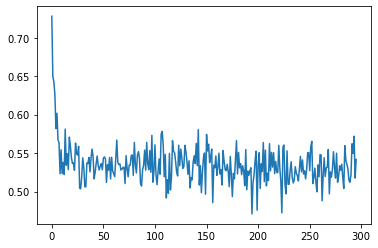

In [ ]:
plt.plot(loss_col)

In [ ]:
torch.save(net, '../data/qual_nets/net1.pkz')

In [ ]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3}
def log_reg(df, weights={}):
    
    df = df.copy()
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [ ]:
gt_dfs = []
pred_dfs = []

for i in tqdm(range(10)):
    
    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        local_rate *= 2

        sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=cfg.genm.exp_type.n_channels, n_bits=4, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=True)
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
        ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)


        noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                       sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

        noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
        xsim += micro(*noise_inp, add_noise=True)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df['gene'] = targets[pred_df['code_inds']]
        pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        
        pred_df = log_reg(pred_df, logr_coefs)
        
        pred_dfs.append(pred_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


In [ ]:
net.eval()
res_df = cat_emitter_dfs(pred_dfs, decode_dl.batch_size)
res_df['net_score'] = cpu(net(input_from_df(res_df)))

In [ ]:
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['class']==1).sum())
        
    return x, n_blanks

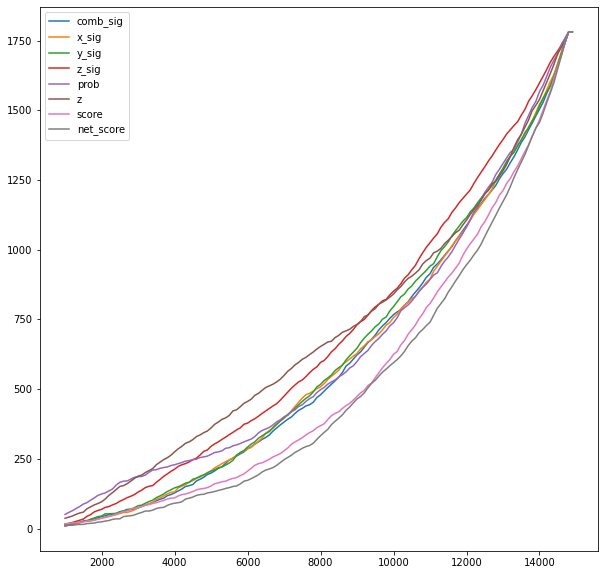

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, n_max=15000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()